In [1]:
# %%
import torch
from torch import nn
import numpy as np

from pit.dynamics.dynamic_bicycle import DynamicBicycle
from pit.integration import Euler, RK4

import matplotlib.pyplot as plt
import json

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(DEVICE)

# input parameters
map_name = 'SaoPaulo'  # Nuerburgring,  SaoPaulo
lap_number = 2  # 1 - faster, 2 - slower
friction = '1-1'  # '1-1' - mu_x = 1.1, '0-7' - mu_x = 0.7

# visualization
with open('dataset_%s_%s_lap%s.json' % (friction, map_name, lap_number), 'r') as f:
    data = json.load(f)

cuda


In [2]:
# %%
timestep = 0.01
assert(data['time'][1] - data['time'][0] - timestep < 0.001)
x = torch.tensor(data['x'])
y = torch.tensor(data['y'])
yaw = torch.tensor(data['yaw'])
vx = torch.tensor(data['vx'])
vy = torch.tensor(data['vy'])
yaw_rate = torch.tensor(data['yaw_rate'])
steer_angle = torch.tensor(data['steer_angle'])
drive_force = torch.tensor(data['drive_force'])
steer_speed = torch.tensor(data['steer_speed'])

In [3]:
# %%
initial_state = torch.tensor([x[0],y[0],yaw[0],vx[0],vy[0],yaw_rate[0],steer_angle[0]]).to(DEVICE)
control_inputs = torch.vstack([drive_force, steer_speed]).T
control_inputs = control_inputs.contiguous().to(DEVICE)
output_states = torch.vstack([x, y, yaw, vx, vy, yaw_rate, steer_angle]).T
target_states = output_states[1:]
target_states = target_states.contiguous().to(DEVICE)

print(f"Inputs size: {control_inputs.shape} | States size: {target_states.shape}")

Inputs size: torch.Size([22486, 2]) | States size: torch.Size([22486, 7])


In [4]:
# %%
STEP_SIZE=10
TICKS_IN_STEP=50
state_dims = initial_state.shape[0]
input_dims = control_inputs.shape[-1]
total_steps = (control_inputs.shape[0]-TICKS_IN_STEP-1)//STEP_SIZE

batched_initial_states = torch.zeros((total_steps, state_dims), device=DEVICE)
batched_control_inputs = torch.zeros((total_steps, TICKS_IN_STEP, input_dims), device=DEVICE)
batched_target_states = torch.zeros((total_steps, TICKS_IN_STEP, state_dims), device=DEVICE)

for step in range(total_steps):
    batched_initial_states[step] = output_states[step*STEP_SIZE]
    batched_control_inputs[step] = control_inputs[step*STEP_SIZE:(step*STEP_SIZE)+TICKS_IN_STEP]
    batched_target_states[step] = output_states[(step*STEP_SIZE)+1:(step*STEP_SIZE)+TICKS_IN_STEP+1]

print(f"Batched Inputs size: {batched_control_inputs.shape} | Batched States size: {batched_target_states.shape}")

Batched Inputs size: torch.Size([2243, 50, 2]) | Batched States size: torch.Size([2243, 50, 7])


In [5]:
# %%
dataset = torch.utils.data.TensorDataset(batched_initial_states, batched_control_inputs, batched_target_states)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1024, shuffle=True)

In [6]:
# %%
params = {
    # axes distances
    'lf': 0.88392,  # distance from spring mass center of gravity to front axle [m]  LENA
    'lr': 1.50876,  # distance from spring mass center of gravity to rear axle [m]  LENB

    # moments of inertia of sprung mass
    # masses
    'Iz': 1538.853371,  # moment of inertia for sprung mass in yaw [kg m^2]  IZZ
    'mass': 1225.887,  # vehicle mass [kg]  MASS

    # Pacejka tire force parameters
    'Df': 3709.08227,  # [rad/m]  DF
    'Cf': 1.3507,
    'Bf': 16.2216,
    'Dr': 3709.08227,  # [rad/m]  DR
    'Cr': 1.3507,
    'Br': 16.2216,
    'Cm': 0.3777,
    'Cr0': 2.1469,
    'Cr2': 0.0,
}
# params.update({
#     "lf" : 0.8839200139045715,
#     "lr" : 1.5087599754333496,
#     "Iz" : 1771.53857421875,
#     "mass" : 701.0275268554688,
#     "Df" : 4041.601318359375,
#     "Cf" : 1.4304611682891846,
#     "Bf" : 18.741268157958984,
#     "Dr" : 3652.13427734375,
#     "Cr" : 0.7047927379608154,
#     "Br" : 27.620542526245117,
#     "Cm" : 0.5324415564537048,
#     "Cr0" : 10.995059967041016,
#     "Cr2" : -0.03063417412340641,
# })
dynamics = DynamicBicycle(**params)
#dynamics = torch.load("fitted_model.pt")
# <---- FIX PHYSICAL PARAMS     ---->
dynamics.lf.requires_grad = False
dynamics.lr.requires_grad = False
dynamics.mass.requires_grad = False
dynamics.Iz.requires_grad = False
dynamics.Df.requires_grad = True
dynamics.Cf.requires_grad = True
dynamics.Bf.requires_grad = True
dynamics.Dr.requires_grad = True
dynamics.Cr.requires_grad = True
dynamics.Br.requires_grad = True
dynamics.Cm.requires_grad = True
dynamics.Cr0.requires_grad = True
dynamics.Cr2.requires_grad = True
# <----                         ---->
euler_integrator = Euler(dynamics, timestep=timestep)
euler_integrator.to(DEVICE)
rk4_integrator = RK4(dynamics=dynamics, timestep=timestep)
rk4_integrator.to(DEVICE)


RK4(
  (dynamics): DynamicBicycle()
)

In [7]:
with torch.no_grad():
    initial_guess_output_states = rk4_integrator(initial_state, control_inputs)


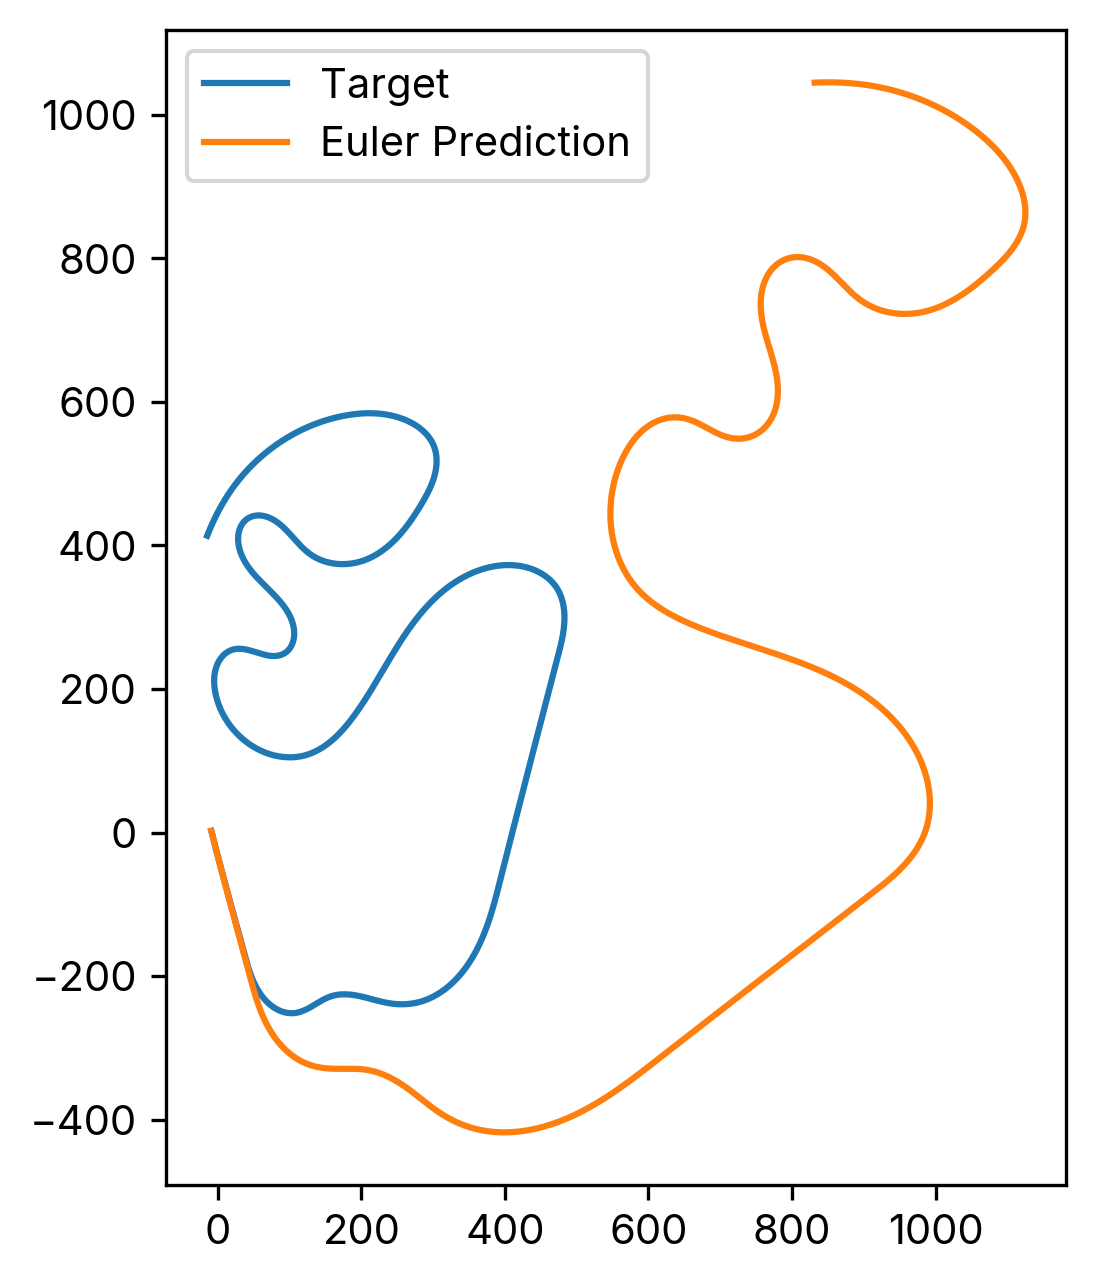

In [25]:
# %%
fig, ax = plt.subplots(1, 1, figsize=(5,5))
LEN=20000
ax.plot(target_states[:LEN, 0].cpu().numpy(), target_states[:LEN, 1].cpu().numpy(), label="Target")
ax.plot(initial_guess_output_states[:LEN, 0].detach().cpu().numpy(), initial_guess_output_states[:LEN, 1].detach().cpu().numpy(), label="Euler Prediction")
#ax.plot(rk4_output_states[:LEN, 0].detach().cpu().numpy(), rk4_output_states[:LEN, 1].detach().cpu().numpy(), label="RK4 Prediction")
ax.set_aspect(1.0)
ax.legend()

In [9]:
# %%
from tqdm.auto import tqdm
EPOCHS = 150
integrator = rk4_integrator
optimizer = torch.optim.SGD(integrator.parameters(), lr=1, momentum=0.8)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.7)

with torch.no_grad():
        output_states = integrator(initial_state, control_inputs)
        val_loss = torch.nn.functional.l1_loss(output_states, target_states)
print(f"Initialized | Validation Loss: {val_loss.item()} | LR: {optimizer.param_groups[0]['lr']}")

losses = list()
lrs = list()

for i in tqdm(range(EPOCHS)):
    for initial, inputs, targets in dataloader:
        optimizer.zero_grad()
        output_states = integrator(initial, inputs)
        loss = torch.nn.functional.l1_loss(output_states, targets)
        loss.backward()
        optimizer.step()
    #for name, param in integrator.named_parameters():
    #    if param.requires_grad:
    #        print(name, param.data, param.grad)
    if i%20 == 0 and False:
        with torch.no_grad():
            output_states = integrator(initial_state, control_inputs)
            val_loss = torch.nn.functional.l1_loss(output_states, target_states)
        fig, ax = plt.subplots(1, 1, figsize=(10,10))
        LEN=20000
        ax.plot(target_states[:LEN, 0].cpu().numpy(), target_states[:LEN, 1].cpu().numpy(), label="Target")
        ax.plot(output_states[:LEN, 0].detach().cpu().numpy(), output_states[:LEN, 1].detach().cpu().numpy(), label="Prediction")
        ax.set_aspect(1.0)
        ax.legend()
        plt.show()
        print(f"Epoch: {i} | Training Loss: {loss.item()} | Validation Loss: {val_loss.item()} | LR: {optimizer.param_groups[0]['lr']}")
    with torch.no_grad():
        output_states = integrator(batched_initial_states,batched_control_inputs)
        val_loss = torch.nn.functional.l1_loss(output_states, batched_target_states)
        losses.append(val_loss.item())
    tqdm.write(f"Epoch: {i} | Training Loss: {loss.item()} | Validation Loss: {val_loss.item()} | LR: {optimizer.param_groups[0]['lr']}")
    lrs.append(optimizer.param_groups[0]['lr'])
    scheduler.step(val_loss)


/root/.pyenv/versions/3.11.9/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Initialized | Validation Loss: 122.80902099609375 | LR: 1


  1%|          | 1/150 [00:03<08:07,  3.27s/it]

Epoch: 0 | Training Loss: 0.03038313053548336 | Validation Loss: 0.02800588868558407 | LR: 1


  1%|▏         | 2/150 [00:06<08:19,  3.37s/it]

Epoch: 1 | Training Loss: 0.03386890888214111 | Validation Loss: 0.026503438130021095 | LR: 1


  2%|▏         | 3/150 [00:10<08:11,  3.35s/it]

Epoch: 2 | Training Loss: 0.022940441966056824 | Validation Loss: 0.024698331952095032 | LR: 1


  3%|▎         | 4/150 [00:13<08:09,  3.35s/it]

Epoch: 3 | Training Loss: 0.03674893081188202 | Validation Loss: 0.02281196229159832 | LR: 1


  3%|▎         | 5/150 [00:16<08:00,  3.32s/it]

Epoch: 4 | Training Loss: 0.01733025722205639 | Validation Loss: 0.020960811525583267 | LR: 1


  4%|▍         | 6/150 [00:20<07:59,  3.33s/it]

Epoch: 5 | Training Loss: 0.019691558554768562 | Validation Loss: 0.01986902579665184 | LR: 1


  5%|▍         | 7/150 [00:23<07:50,  3.29s/it]

Epoch: 6 | Training Loss: 0.018876394256949425 | Validation Loss: 0.019382495433092117 | LR: 1


  5%|▌         | 8/150 [00:26<07:44,  3.27s/it]

Epoch: 7 | Training Loss: 0.022114528343081474 | Validation Loss: 0.01846545748412609 | LR: 1


  6%|▌         | 9/150 [00:29<07:40,  3.27s/it]

Epoch: 8 | Training Loss: 0.018734784796833992 | Validation Loss: 0.018031643703579903 | LR: 1


  7%|▋         | 10/150 [00:33<07:40,  3.29s/it]

Epoch: 9 | Training Loss: 0.013851785100996494 | Validation Loss: 0.01754985935986042 | LR: 1


  7%|▋         | 11/150 [00:36<07:33,  3.27s/it]

Epoch: 10 | Training Loss: 0.019826695322990417 | Validation Loss: 0.017153507098555565 | LR: 1


  8%|▊         | 12/150 [00:39<07:28,  3.25s/it]

Epoch: 11 | Training Loss: 0.018151508644223213 | Validation Loss: 0.016818303614854813 | LR: 1


  9%|▊         | 13/150 [00:42<07:27,  3.27s/it]

Epoch: 12 | Training Loss: 0.00909387692809105 | Validation Loss: 0.016513802111148834 | LR: 1


  9%|▉         | 14/150 [00:45<07:21,  3.25s/it]

Epoch: 13 | Training Loss: 0.015331456437706947 | Validation Loss: 0.016237663105130196 | LR: 1


 10%|█         | 15/150 [00:49<07:16,  3.24s/it]

Epoch: 14 | Training Loss: 0.012861608527600765 | Validation Loss: 0.015981808304786682 | LR: 1


 11%|█         | 16/150 [00:52<07:12,  3.23s/it]

Epoch: 15 | Training Loss: 0.013468940742313862 | Validation Loss: 0.015739573165774345 | LR: 1


 11%|█▏        | 17/150 [00:55<07:13,  3.26s/it]

Epoch: 16 | Training Loss: 0.008277134969830513 | Validation Loss: 0.015513026155531406 | LR: 1


 12%|█▏        | 18/150 [00:58<07:08,  3.24s/it]

Epoch: 17 | Training Loss: 0.011951261200010777 | Validation Loss: 0.015305602923035622 | LR: 1


 13%|█▎        | 19/150 [01:02<07:03,  3.24s/it]

Epoch: 18 | Training Loss: 0.016255810856819153 | Validation Loss: 0.015112457796931267 | LR: 1


 13%|█▎        | 20/150 [01:05<07:00,  3.23s/it]

Epoch: 19 | Training Loss: 0.016860192641615868 | Validation Loss: 0.014930644072592258 | LR: 1


 14%|█▍        | 21/150 [01:08<07:00,  3.26s/it]

Epoch: 20 | Training Loss: 0.018380802124738693 | Validation Loss: 0.01475529931485653 | LR: 1


 15%|█▍        | 22/150 [01:11<06:55,  3.25s/it]

Epoch: 21 | Training Loss: 0.011702816933393478 | Validation Loss: 0.01459127850830555 | LR: 1


 15%|█▌        | 23/150 [01:15<06:51,  3.24s/it]

Epoch: 22 | Training Loss: 0.010978472419083118 | Validation Loss: 0.014435265213251114 | LR: 1


 16%|█▌        | 24/150 [01:18<06:46,  3.23s/it]

Epoch: 23 | Training Loss: 0.009944790042936802 | Validation Loss: 0.014286460354924202 | LR: 1


 17%|█▋        | 25/150 [01:21<06:47,  3.26s/it]

Epoch: 24 | Training Loss: 0.01170883048325777 | Validation Loss: 0.014144881628453732 | LR: 1


 17%|█▋        | 26/150 [01:24<06:42,  3.25s/it]

Epoch: 25 | Training Loss: 0.011745461262762547 | Validation Loss: 0.014010181650519371 | LR: 1


 18%|█▊        | 27/150 [01:28<06:38,  3.24s/it]

Epoch: 26 | Training Loss: 0.016040116548538208 | Validation Loss: 0.013882571831345558 | LR: 1


 19%|█▊        | 28/150 [01:31<06:33,  3.23s/it]

Epoch: 27 | Training Loss: 0.008749375119805336 | Validation Loss: 0.013765154406428337 | LR: 1


 19%|█▉        | 29/150 [01:34<06:34,  3.26s/it]

Epoch: 28 | Training Loss: 0.01840401068329811 | Validation Loss: 0.013660607859492302 | LR: 1


 20%|██        | 30/150 [01:37<06:29,  3.25s/it]

Epoch: 29 | Training Loss: 0.008938238956034184 | Validation Loss: 0.013561652973294258 | LR: 1


 21%|██        | 31/150 [01:41<06:25,  3.24s/it]

Epoch: 30 | Training Loss: 0.012697572819888592 | Validation Loss: 0.013510840013623238 | LR: 1


 21%|██▏       | 32/150 [01:44<06:21,  3.23s/it]

Epoch: 31 | Training Loss: 0.015234578400850296 | Validation Loss: 0.013444158248603344 | LR: 1


 22%|██▏       | 33/150 [01:47<06:21,  3.26s/it]

Epoch: 32 | Training Loss: 0.008423454128205776 | Validation Loss: 0.013406537473201752 | LR: 1


 23%|██▎       | 34/150 [01:50<06:16,  3.24s/it]

Epoch: 33 | Training Loss: 0.007328525651246309 | Validation Loss: 0.013377711176872253 | LR: 1


 23%|██▎       | 35/150 [01:54<06:12,  3.24s/it]

Epoch: 34 | Training Loss: 0.009703380055725574 | Validation Loss: 0.013356886804103851 | LR: 1


 24%|██▍       | 36/150 [01:57<06:12,  3.27s/it]

Epoch: 35 | Training Loss: 0.010702959261834621 | Validation Loss: 0.01334177516400814 | LR: 1


 25%|██▍       | 37/150 [02:00<06:08,  3.26s/it]

Epoch: 36 | Training Loss: 0.007811163552105427 | Validation Loss: 0.0133298859000206 | LR: 1


 25%|██▌       | 38/150 [02:03<06:03,  3.24s/it]

Epoch: 37 | Training Loss: 0.009834677912294865 | Validation Loss: 0.013324732892215252 | LR: 1


 26%|██▌       | 39/150 [02:07<05:59,  3.24s/it]

Epoch: 38 | Training Loss: 0.011623159050941467 | Validation Loss: 0.01331726461648941 | LR: 1


 27%|██▋       | 40/150 [02:10<05:59,  3.27s/it]

Epoch: 39 | Training Loss: 0.015440697781741619 | Validation Loss: 0.013311151415109634 | LR: 1


 27%|██▋       | 41/150 [02:13<05:54,  3.25s/it]

Epoch: 40 | Training Loss: 0.006302715744823217 | Validation Loss: 0.013306356966495514 | LR: 1


 28%|██▊       | 42/150 [02:16<05:50,  3.24s/it]

Epoch: 41 | Training Loss: 0.006446288898587227 | Validation Loss: 0.013303842395544052 | LR: 1


 29%|██▊       | 43/150 [02:20<05:46,  3.23s/it]

Epoch: 42 | Training Loss: 0.020078327506780624 | Validation Loss: 0.013301205821335316 | LR: 1


 29%|██▉       | 44/150 [02:23<05:46,  3.27s/it]

Epoch: 43 | Training Loss: 0.01538969948887825 | Validation Loss: 0.013303195126354694 | LR: 1


 30%|███       | 45/150 [02:26<05:41,  3.26s/it]

Epoch: 44 | Training Loss: 0.008779098279774189 | Validation Loss: 0.013304691761732101 | LR: 1


 31%|███       | 46/150 [02:29<05:37,  3.25s/it]

Epoch: 45 | Training Loss: 0.012769483029842377 | Validation Loss: 0.013298054225742817 | LR: 1


 31%|███▏      | 47/150 [02:33<05:33,  3.24s/it]

Epoch: 46 | Training Loss: 0.00993844959884882 | Validation Loss: 0.013303842395544052 | LR: 1


 32%|███▏      | 48/150 [02:36<05:33,  3.27s/it]

Epoch: 47 | Training Loss: 0.01894492097198963 | Validation Loss: 0.013296516612172127 | LR: 1


 33%|███▎      | 49/150 [02:39<05:29,  3.26s/it]

Epoch: 48 | Training Loss: 0.013842524029314518 | Validation Loss: 0.013296256773173809 | LR: 1


 33%|███▎      | 50/150 [02:42<05:24,  3.25s/it]

Epoch: 49 | Training Loss: 0.008139182813465595 | Validation Loss: 0.013296939432621002 | LR: 1


 34%|███▍      | 51/150 [02:46<05:20,  3.24s/it]

Epoch: 50 | Training Loss: 0.021386314183473587 | Validation Loss: 0.013294429518282413 | LR: 1


 35%|███▍      | 52/150 [02:49<05:20,  3.27s/it]

Epoch: 51 | Training Loss: 0.01486013364046812 | Validation Loss: 0.013294056989252567 | LR: 1


 35%|███▌      | 53/150 [02:52<05:15,  3.25s/it]

Epoch: 52 | Training Loss: 0.010534213855862617 | Validation Loss: 0.013294793665409088 | LR: 1


 36%|███▌      | 54/150 [02:55<05:11,  3.24s/it]

Epoch: 53 | Training Loss: 0.013720745220780373 | Validation Loss: 0.01329860184341669 | LR: 1


 37%|███▋      | 55/150 [02:59<05:07,  3.24s/it]

Epoch: 54 | Training Loss: 0.005994841456413269 | Validation Loss: 0.013293690048158169 | LR: 1


 37%|███▋      | 56/150 [03:02<05:06,  3.26s/it]

Epoch: 55 | Training Loss: 0.015555514954030514 | Validation Loss: 0.0132980328053236 | LR: 1


 38%|███▊      | 57/150 [03:05<05:02,  3.25s/it]

Epoch: 56 | Training Loss: 0.005665117409080267 | Validation Loss: 0.013297214172780514 | LR: 1


 39%|███▊      | 58/150 [03:08<04:58,  3.24s/it]

Epoch: 57 | Training Loss: 0.010083578526973724 | Validation Loss: 0.013293333351612091 | LR: 1


 39%|███▉      | 59/150 [03:12<04:58,  3.28s/it]

Epoch: 58 | Training Loss: 0.0146424425765872 | Validation Loss: 0.013294731266796589 | LR: 1


 40%|████      | 60/150 [03:15<04:53,  3.26s/it]

Epoch: 59 | Training Loss: 0.00950601790100336 | Validation Loss: 0.013293500989675522 | LR: 1


 41%|████      | 61/150 [03:18<04:49,  3.25s/it]

Epoch: 60 | Training Loss: 0.012263315729796886 | Validation Loss: 0.013296345248818398 | LR: 1


 41%|████▏     | 62/150 [03:21<04:45,  3.24s/it]

Epoch: 61 | Training Loss: 0.009133949875831604 | Validation Loss: 0.013296612538397312 | LR: 1


 42%|████▏     | 63/150 [03:25<04:45,  3.28s/it]

Epoch: 62 | Training Loss: 0.019657358527183533 | Validation Loss: 0.013293351978063583 | LR: 0.7


 43%|████▎     | 64/150 [03:28<04:41,  3.27s/it]

Epoch: 63 | Training Loss: 0.008774706162512302 | Validation Loss: 0.013293071649968624 | LR: 0.7


 43%|████▎     | 65/150 [03:31<04:36,  3.26s/it]

Epoch: 64 | Training Loss: 0.011948440223932266 | Validation Loss: 0.013292795978486538 | LR: 0.7


 44%|████▍     | 66/150 [03:34<04:32,  3.24s/it]

Epoch: 65 | Training Loss: 0.00825544074177742 | Validation Loss: 0.013293163850903511 | LR: 0.7


 45%|████▍     | 67/150 [03:38<04:31,  3.27s/it]

Epoch: 66 | Training Loss: 0.012973698787391186 | Validation Loss: 0.013293223455548286 | LR: 0.7


 45%|████▌     | 68/150 [03:41<04:26,  3.25s/it]

Epoch: 67 | Training Loss: 0.015608025714755058 | Validation Loss: 0.013293223455548286 | LR: 0.7


 46%|████▌     | 69/150 [03:44<04:22,  3.24s/it]

Epoch: 68 | Training Loss: 0.01698913611471653 | Validation Loss: 0.013293074443936348 | LR: 0.7


 47%|████▋     | 70/150 [03:47<04:18,  3.23s/it]

Epoch: 69 | Training Loss: 0.01869605854153633 | Validation Loss: 0.013294084928929806 | LR: 0.7


 47%|████▋     | 71/150 [03:51<04:17,  3.26s/it]

Epoch: 70 | Training Loss: 0.012791737914085388 | Validation Loss: 0.013293181546032429 | LR: 0.7


 48%|████▊     | 72/150 [03:54<04:12,  3.24s/it]

Epoch: 71 | Training Loss: 0.013073215261101723 | Validation Loss: 0.013293541967868805 | LR: 0.7


 49%|████▊     | 73/150 [03:57<04:08,  3.23s/it]

Epoch: 72 | Training Loss: 0.012596235610544682 | Validation Loss: 0.013293074443936348 | LR: 0.7


 49%|████▉     | 74/150 [04:00<04:05,  3.23s/it]

Epoch: 73 | Training Loss: 0.013205432333052158 | Validation Loss: 0.013293400406837463 | LR: 0.7


 50%|█████     | 75/150 [04:04<04:03,  3.25s/it]

Epoch: 74 | Training Loss: 0.008551320992410183 | Validation Loss: 0.013296098448336124 | LR: 0.7


 51%|█████     | 76/150 [04:07<03:59,  3.24s/it]

Epoch: 75 | Training Loss: 0.009618173353374004 | Validation Loss: 0.01329439040273428 | LR: 0.48999999999999994


 51%|█████▏    | 77/150 [04:10<03:56,  3.24s/it]

Epoch: 76 | Training Loss: 0.023548549041152 | Validation Loss: 0.013294082134962082 | LR: 0.48999999999999994


 52%|█████▏    | 78/150 [04:13<03:52,  3.23s/it]

Epoch: 77 | Training Loss: 0.01579558104276657 | Validation Loss: 0.013293188996613026 | LR: 0.48999999999999994


 53%|█████▎    | 79/150 [04:17<03:51,  3.26s/it]

Epoch: 78 | Training Loss: 0.014990490861237049 | Validation Loss: 0.013294783420860767 | LR: 0.48999999999999994


 53%|█████▎    | 80/150 [04:20<03:47,  3.25s/it]

Epoch: 79 | Training Loss: 0.014541353099048138 | Validation Loss: 0.013293851166963577 | LR: 0.48999999999999994


 54%|█████▍    | 81/150 [04:23<03:43,  3.24s/it]

Epoch: 80 | Training Loss: 0.008901303634047508 | Validation Loss: 0.013292980380356312 | LR: 0.48999999999999994


 55%|█████▍    | 82/150 [04:26<03:41,  3.26s/it]

Epoch: 81 | Training Loss: 0.014197454787790775 | Validation Loss: 0.01329276617616415 | LR: 0.48999999999999994


 55%|█████▌    | 83/150 [04:30<03:37,  3.25s/it]

Epoch: 82 | Training Loss: 0.014820974320173264 | Validation Loss: 0.013292888179421425 | LR: 0.48999999999999994


 56%|█████▌    | 84/150 [04:33<03:33,  3.24s/it]

Epoch: 83 | Training Loss: 0.018635958433151245 | Validation Loss: 0.013293145224452019 | LR: 0.48999999999999994


 57%|█████▋    | 85/150 [04:36<03:29,  3.23s/it]

Epoch: 84 | Training Loss: 0.020244255661964417 | Validation Loss: 0.013292822986841202 | LR: 0.48999999999999994


 57%|█████▋    | 86/150 [04:39<03:28,  3.26s/it]

Epoch: 85 | Training Loss: 0.0113326171413064 | Validation Loss: 0.013292763382196426 | LR: 0.48999999999999994


 58%|█████▊    | 87/150 [04:43<03:24,  3.25s/it]

Epoch: 86 | Training Loss: 0.015969231724739075 | Validation Loss: 0.013293188065290451 | LR: 0.3429999999999999


 59%|█████▊    | 88/150 [04:46<03:20,  3.23s/it]

Epoch: 87 | Training Loss: 0.01502411812543869 | Validation Loss: 0.013292855583131313 | LR: 0.3429999999999999


 59%|█████▉    | 89/150 [04:49<03:16,  3.23s/it]

Epoch: 88 | Training Loss: 0.01543927937746048 | Validation Loss: 0.01329284068197012 | LR: 0.3429999999999999


 60%|██████    | 90/150 [04:52<03:15,  3.26s/it]

Epoch: 89 | Training Loss: 0.014003279618918896 | Validation Loss: 0.01329264510422945 | LR: 0.3429999999999999


 61%|██████    | 91/150 [04:56<03:11,  3.25s/it]

Epoch: 90 | Training Loss: 0.018977155908942223 | Validation Loss: 0.013292730785906315 | LR: 0.3429999999999999


 61%|██████▏   | 92/150 [04:59<03:07,  3.23s/it]

Epoch: 91 | Training Loss: 0.013973363675177097 | Validation Loss: 0.013292687945067883 | LR: 0.3429999999999999


 62%|██████▏   | 93/150 [05:02<03:04,  3.23s/it]

Epoch: 92 | Training Loss: 0.01736997254192829 | Validation Loss: 0.013292822055518627 | LR: 0.3429999999999999


 63%|██████▎   | 94/150 [05:05<03:02,  3.25s/it]

Epoch: 93 | Training Loss: 0.018739603459835052 | Validation Loss: 0.013292800635099411 | LR: 0.3429999999999999


 63%|██████▎   | 95/150 [05:08<02:58,  3.25s/it]

Epoch: 94 | Training Loss: 0.010929955169558525 | Validation Loss: 0.013292803429067135 | LR: 0.3429999999999999


 64%|██████▍   | 96/150 [05:12<02:54,  3.24s/it]

Epoch: 95 | Training Loss: 0.009558917954564095 | Validation Loss: 0.013292815536260605 | LR: 0.3429999999999999


 65%|██████▍   | 97/150 [05:15<02:51,  3.23s/it]

Epoch: 96 | Training Loss: 0.016008708626031876 | Validation Loss: 0.013293352909386158 | LR: 0.3429999999999999


 65%|██████▌   | 98/150 [05:18<02:49,  3.25s/it]

Epoch: 97 | Training Loss: 0.01097207609564066 | Validation Loss: 0.013292614370584488 | LR: 0.24009999999999992


 66%|██████▌   | 99/150 [05:21<02:45,  3.24s/it]

Epoch: 98 | Training Loss: 0.009497428312897682 | Validation Loss: 0.013292781077325344 | LR: 0.24009999999999992


 67%|██████▋   | 100/150 [05:25<02:41,  3.23s/it]

Epoch: 99 | Training Loss: 0.010774156078696251 | Validation Loss: 0.013292936608195305 | LR: 0.24009999999999992


 67%|██████▋   | 101/150 [05:28<02:38,  3.22s/it]

Epoch: 100 | Training Loss: 0.00993888545781374 | Validation Loss: 0.013292821124196053 | LR: 0.24009999999999992


 68%|██████▊   | 102/150 [05:31<02:36,  3.26s/it]

Epoch: 101 | Training Loss: 0.008498510345816612 | Validation Loss: 0.013292676769196987 | LR: 0.24009999999999992


 69%|██████▊   | 103/150 [05:34<02:32,  3.24s/it]

Epoch: 102 | Training Loss: 0.011548937298357487 | Validation Loss: 0.013292806223034859 | LR: 0.24009999999999992


 69%|██████▉   | 104/150 [05:38<02:28,  3.23s/it]

Epoch: 103 | Training Loss: 0.016754820942878723 | Validation Loss: 0.013292666524648666 | LR: 0.24009999999999992


 70%|███████   | 105/150 [05:41<02:26,  3.26s/it]

Epoch: 104 | Training Loss: 0.014244143851101398 | Validation Loss: 0.013292702846229076 | LR: 0.24009999999999992


 71%|███████   | 106/150 [05:44<02:22,  3.24s/it]

Epoch: 105 | Training Loss: 0.01853015460073948 | Validation Loss: 0.01329266931861639 | LR: 0.24009999999999992


 71%|███████▏  | 107/150 [05:47<02:18,  3.23s/it]

Epoch: 106 | Training Loss: 0.007925521582365036 | Validation Loss: 0.013292763382196426 | LR: 0.24009999999999992


 72%|███████▏  | 108/150 [05:51<02:15,  3.23s/it]

Epoch: 107 | Training Loss: 0.011870033107697964 | Validation Loss: 0.01329276617616415 | LR: 0.24009999999999992


 73%|███████▎  | 109/150 [05:54<02:13,  3.26s/it]

Epoch: 108 | Training Loss: 0.022165555506944656 | Validation Loss: 0.013292686082422733 | LR: 0.16806999999999994


 73%|███████▎  | 110/150 [05:57<02:09,  3.24s/it]

Epoch: 109 | Training Loss: 0.02017192728817463 | Validation Loss: 0.013292745687067509 | LR: 0.16806999999999994


 74%|███████▍  | 111/150 [06:00<02:06,  3.24s/it]

Epoch: 110 | Training Loss: 0.020084001123905182 | Validation Loss: 0.013292712159454823 | LR: 0.16806999999999994


 75%|███████▍  | 112/150 [06:04<02:02,  3.23s/it]

Epoch: 111 | Training Loss: 0.015547718852758408 | Validation Loss: 0.013292825780808926 | LR: 0.16806999999999994


 75%|███████▌  | 113/150 [06:07<02:00,  3.26s/it]

Epoch: 112 | Training Loss: 0.016397299244999886 | Validation Loss: 0.013292661868035793 | LR: 0.16806999999999994


 76%|███████▌  | 114/150 [06:10<01:56,  3.25s/it]

Epoch: 113 | Training Loss: 0.01422069501131773 | Validation Loss: 0.013292703777551651 | LR: 0.16806999999999994


 77%|███████▋  | 115/150 [06:13<01:53,  3.24s/it]

Epoch: 114 | Training Loss: 0.01118498295545578 | Validation Loss: 0.013292699120938778 | LR: 0.16806999999999994


 77%|███████▋  | 116/150 [06:17<01:49,  3.23s/it]

Epoch: 115 | Training Loss: 0.021085962653160095 | Validation Loss: 0.013292822055518627 | LR: 0.16806999999999994


 78%|███████▊  | 117/150 [06:20<01:47,  3.26s/it]

Epoch: 116 | Training Loss: 0.01451251469552517 | Validation Loss: 0.01329274382442236 | LR: 0.16806999999999994


 79%|███████▊  | 118/150 [06:23<01:43,  3.25s/it]

Epoch: 117 | Training Loss: 0.00833193864673376 | Validation Loss: 0.01329277828335762 | LR: 0.16806999999999994


 79%|███████▉  | 119/150 [06:26<01:40,  3.24s/it]

Epoch: 118 | Training Loss: 0.016229402273893356 | Validation Loss: 0.013292700052261353 | LR: 0.16806999999999994


 80%|████████  | 120/150 [06:30<01:37,  3.24s/it]

Epoch: 119 | Training Loss: 0.02336946874856949 | Validation Loss: 0.01329270750284195 | LR: 0.11764899999999995


 81%|████████  | 121/150 [06:33<01:34,  3.26s/it]

Epoch: 120 | Training Loss: 0.01628844253718853 | Validation Loss: 0.013292725197970867 | LR: 0.11764899999999995


 81%|████████▏ | 122/150 [06:36<01:31,  3.25s/it]

Epoch: 121 | Training Loss: 0.0097418874502182 | Validation Loss: 0.013292691670358181 | LR: 0.11764899999999995


 82%|████████▏ | 123/150 [06:39<01:27,  3.24s/it]

Epoch: 122 | Training Loss: 0.010762988589704037 | Validation Loss: 0.013292733579874039 | LR: 0.11764899999999995


 83%|████████▎ | 124/150 [06:43<01:24,  3.23s/it]

Epoch: 123 | Training Loss: 0.02219514362514019 | Validation Loss: 0.013292715884745121 | LR: 0.11764899999999995


 83%|████████▎ | 125/150 [06:46<01:21,  3.26s/it]

Epoch: 124 | Training Loss: 0.015723586082458496 | Validation Loss: 0.01329269353300333 | LR: 0.11764899999999995


 84%|████████▍ | 126/150 [06:49<01:17,  3.24s/it]

Epoch: 125 | Training Loss: 0.01646599732339382 | Validation Loss: 0.013292718678712845 | LR: 0.11764899999999995


 85%|████████▍ | 127/150 [06:52<01:14,  3.24s/it]

Epoch: 126 | Training Loss: 0.013374870643019676 | Validation Loss: 0.013292907737195492 | LR: 0.11764899999999995


 85%|████████▌ | 128/150 [06:56<01:11,  3.26s/it]

Epoch: 127 | Training Loss: 0.005846794694662094 | Validation Loss: 0.013292722404003143 | LR: 0.11764899999999995


 86%|████████▌ | 129/150 [06:59<01:08,  3.25s/it]

Epoch: 128 | Training Loss: 0.011045766063034534 | Validation Loss: 0.013292855583131313 | LR: 0.11764899999999995


 87%|████████▋ | 130/150 [07:02<01:04,  3.24s/it]

Epoch: 129 | Training Loss: 0.01556765753775835 | Validation Loss: 0.013292666524648666 | LR: 0.11764899999999995


 87%|████████▋ | 131/150 [07:05<01:01,  3.23s/it]

Epoch: 130 | Training Loss: 0.014364550821483135 | Validation Loss: 0.01329269539564848 | LR: 0.08235429999999996


 88%|████████▊ | 132/150 [07:09<00:58,  3.27s/it]

Epoch: 131 | Training Loss: 0.017923884093761444 | Validation Loss: 0.013292730785906315 | LR: 0.08235429999999996


 89%|████████▊ | 133/150 [07:12<00:55,  3.25s/it]

Epoch: 132 | Training Loss: 0.005849223583936691 | Validation Loss: 0.013292708434164524 | LR: 0.08235429999999996


 89%|████████▉ | 134/150 [07:15<00:51,  3.24s/it]

Epoch: 133 | Training Loss: 0.01582523062825203 | Validation Loss: 0.013292706571519375 | LR: 0.08235429999999996


 90%|█████████ | 135/150 [07:18<00:48,  3.23s/it]

Epoch: 134 | Training Loss: 0.009528045542538166 | Validation Loss: 0.013292772695422173 | LR: 0.08235429999999996


 91%|█████████ | 136/150 [07:22<00:45,  3.26s/it]

Epoch: 135 | Training Loss: 0.009023989550769329 | Validation Loss: 0.013292721472680569 | LR: 0.08235429999999996


 91%|█████████▏| 137/150 [07:25<00:42,  3.25s/it]

Epoch: 136 | Training Loss: 0.027307912707328796 | Validation Loss: 0.013292726129293442 | LR: 0.08235429999999996


 92%|█████████▏| 138/150 [07:28<00:38,  3.24s/it]

Epoch: 137 | Training Loss: 0.01119063701480627 | Validation Loss: 0.013292803429067135 | LR: 0.08235429999999996


 93%|█████████▎| 139/150 [07:31<00:35,  3.23s/it]

Epoch: 138 | Training Loss: 0.01513537485152483 | Validation Loss: 0.01329269539564848 | LR: 0.08235429999999996


 93%|█████████▎| 140/150 [07:35<00:32,  3.26s/it]

Epoch: 139 | Training Loss: 0.010488145053386688 | Validation Loss: 0.013292758725583553 | LR: 0.08235429999999996


 94%|█████████▍| 141/150 [07:38<00:29,  3.25s/it]

Epoch: 140 | Training Loss: 0.010457129217684269 | Validation Loss: 0.01329282857477665 | LR: 0.08235429999999996


 95%|█████████▍| 142/150 [07:41<00:25,  3.24s/it]

Epoch: 141 | Training Loss: 0.0057042608968913555 | Validation Loss: 0.013292788527905941 | LR: 0.05764800999999997


 95%|█████████▌| 143/150 [07:44<00:22,  3.23s/it]

Epoch: 142 | Training Loss: 0.009714782238006592 | Validation Loss: 0.013292696326971054 | LR: 0.05764800999999997


 96%|█████████▌| 144/150 [07:47<00:19,  3.26s/it]

Epoch: 143 | Training Loss: 0.014252299442887306 | Validation Loss: 0.013292728923261166 | LR: 0.05764800999999997


 97%|█████████▋| 145/150 [07:51<00:16,  3.25s/it]

Epoch: 144 | Training Loss: 0.006549527868628502 | Validation Loss: 0.01329269353300333 | LR: 0.05764800999999997


 97%|█████████▋| 146/150 [07:54<00:12,  3.24s/it]

Epoch: 145 | Training Loss: 0.01324971579015255 | Validation Loss: 0.013292629271745682 | LR: 0.05764800999999997


 98%|█████████▊| 147/150 [07:57<00:09,  3.23s/it]

Epoch: 146 | Training Loss: 0.005603778176009655 | Validation Loss: 0.013292676769196987 | LR: 0.05764800999999997


 99%|█████████▊| 148/150 [08:00<00:06,  3.26s/it]

Epoch: 147 | Training Loss: 0.012935408391058445 | Validation Loss: 0.013292721472680569 | LR: 0.05764800999999997


 99%|█████████▉| 149/150 [08:04<00:03,  3.25s/it]

Epoch: 148 | Training Loss: 0.014961523935198784 | Validation Loss: 0.013292776420712471 | LR: 0.05764800999999997


100%|██████████| 150/150 [08:07<00:00,  3.25s/it]

Epoch: 149 | Training Loss: 0.011095112189650536 | Validation Loss: 0.013292761519551277 | LR: 0.05764800999999997


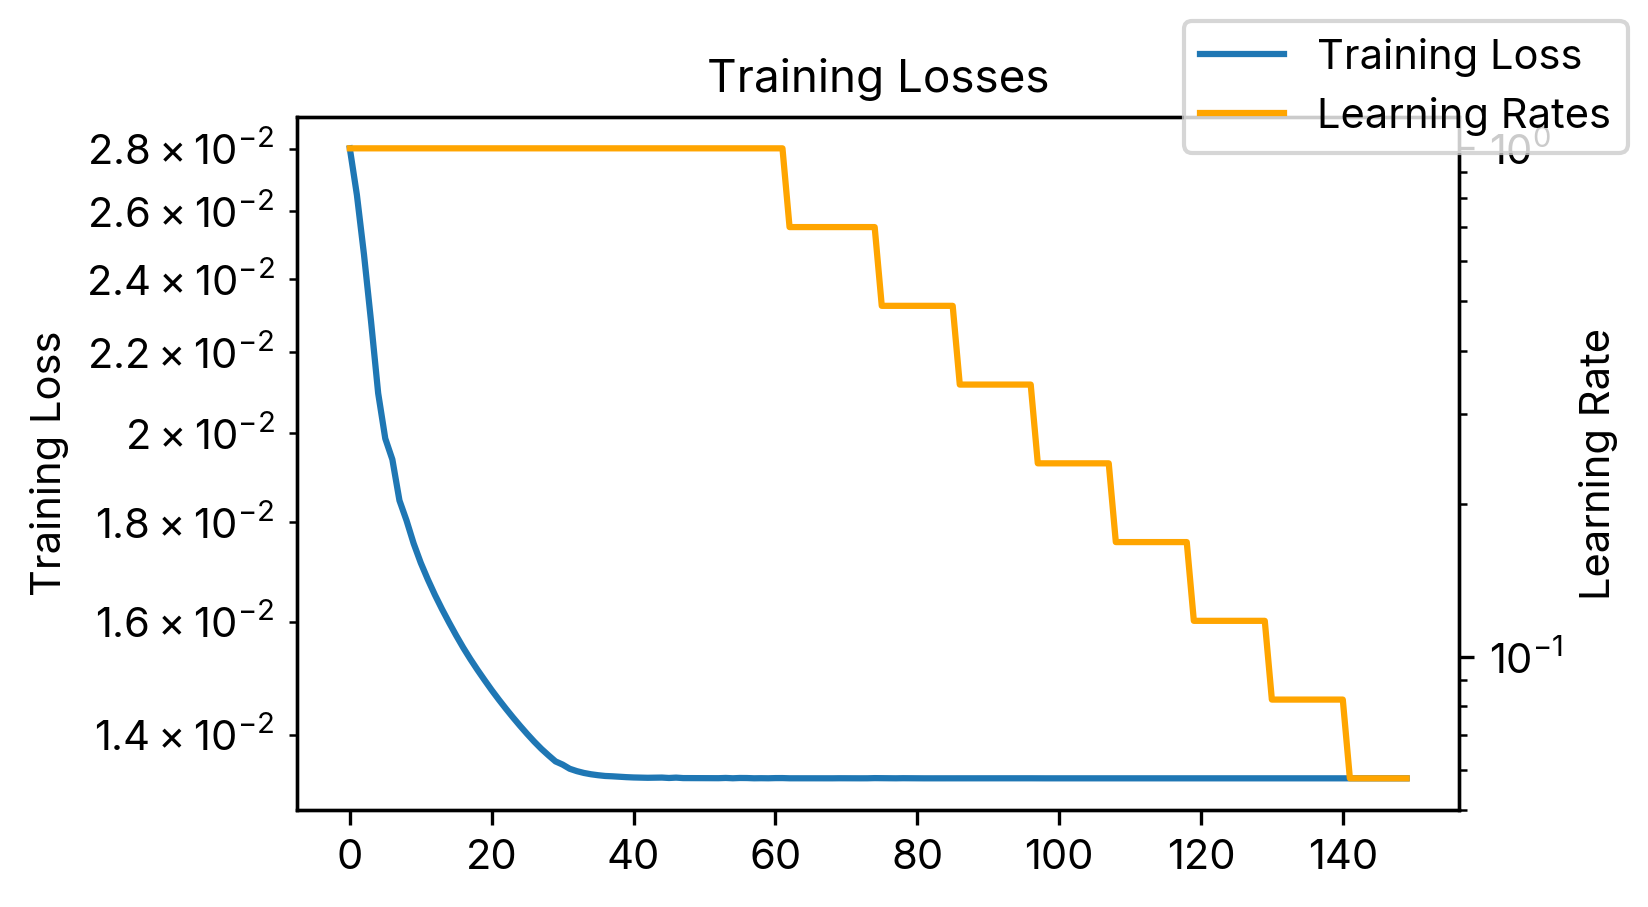

In [29]:
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(losses, label='Training Loss')
ax.set_ylabel("Training Loss")
ax.set_yscale('log')
secax = ax.twinx()
secax.set_ylabel("Learning Rate")
secax.plot(lrs, label="Learning Rates", color='orange')
secax.set_yscale('log')
ax.set_title("Training Losses")
fig.legend()
plt.show()

In [11]:
# %%
with torch.no_grad():
    output_states = integrator(initial_state, control_inputs)
    val_loss = torch.nn.functional.l1_loss(output_states, target_states)

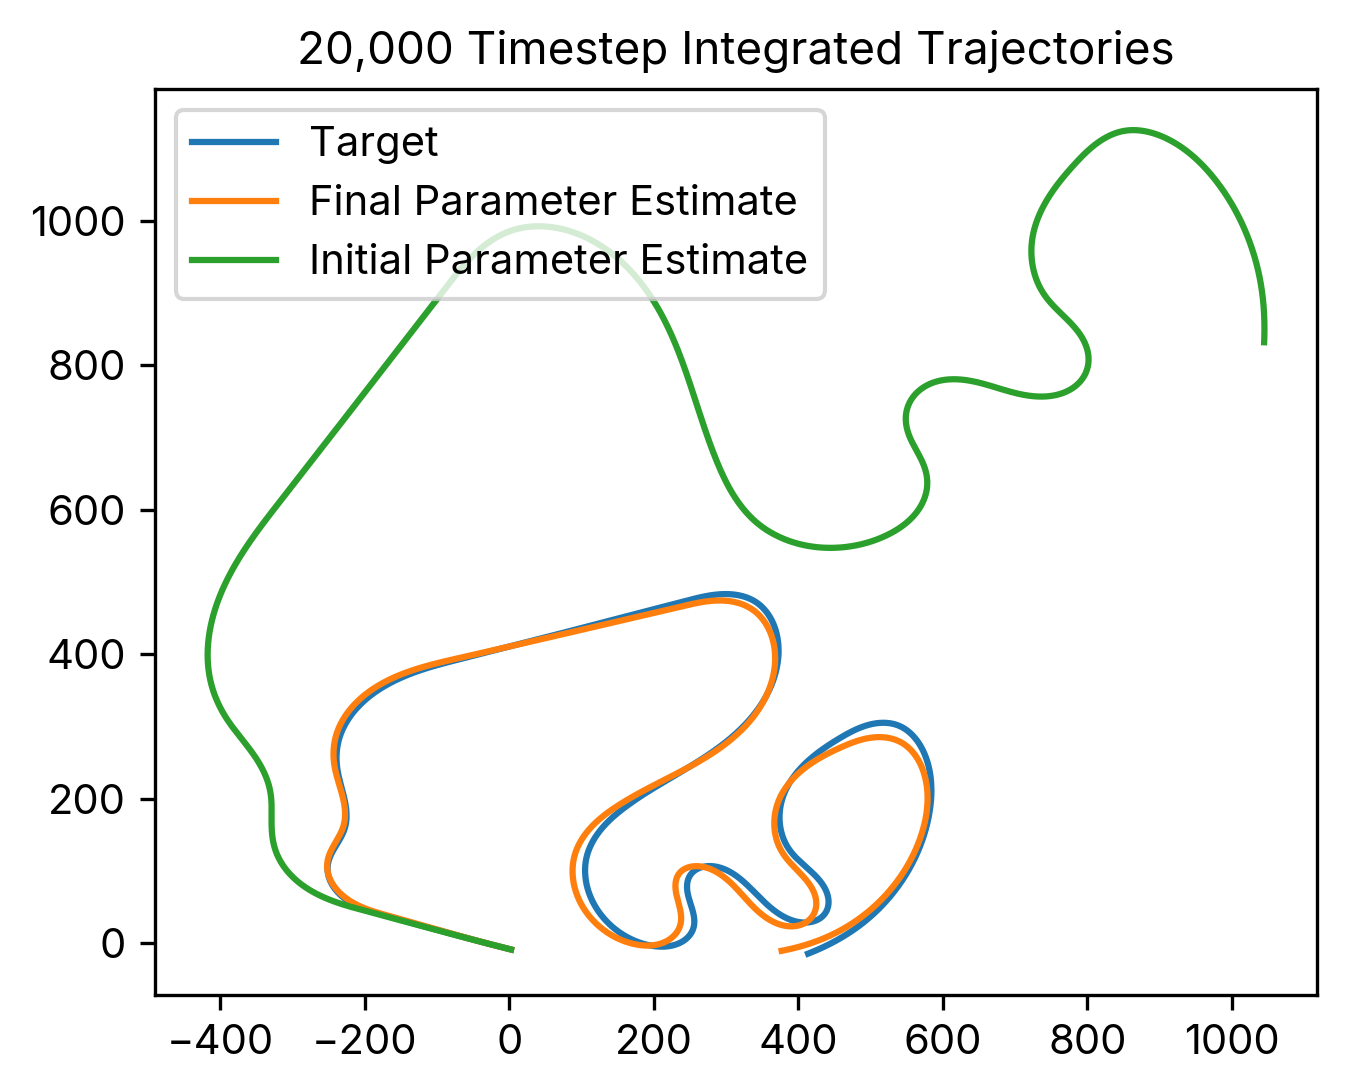

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
LEN=20000
ax.plot(target_states[:LEN, 1].cpu().numpy(), target_states[:LEN, 0].cpu().numpy(), label="Target")
ax.plot(output_states[:LEN, 1].detach().cpu().numpy(), output_states[:LEN, 0].detach().cpu().numpy(), label="Final Parameter Estimate")
ax.plot(initial_guess_output_states[:LEN, 1].detach().cpu().numpy(), initial_guess_output_states[:LEN, 0].detach().cpu().numpy(), label="Initial Parameter Estimate")
ax.set_aspect(1.0)
ax.legend()
ax.set_title("20,000 Timestep Integrated Trajectories")
plt.savefig("integrated_traj.pdf", bbox_inches='tight')
plt.show()

In [24]:
torch.norm(output_states[:,:2] - target_states[:,:2])/output_states.shape[0]

tensor(0.1687, device='cuda:0')

In [22]:
output_states.shape

torch.Size([22486, 7])

In [13]:
print("{")
for key in dynamics.state_dict().keys():
    print(f"\t\"{key}\" : {dynamics.state_dict()[key]},")
print("}")

{
	"lf" : 0.8839200139045715,
	"lr" : 1.5087599754333496,
	"Iz" : 1538.8533935546875,
	"mass" : 1225.886962890625,
	"Df" : 3709.082275390625,
	"Cf" : 3.4608092308044434,
	"Bf" : 16.50495719909668,
	"Dr" : 3709.082275390625,
	"Cr" : 2.081909418106079,
	"Br" : 16.301834106445312,
	"Cm" : 0.9564632177352905,
	"Cr0" : 2.1426515579223633,
	"Cr2" : -0.010176454670727253,
}
